In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score

def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from glob import glob

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('D:\\Data\\AI604_project\\NIH\\Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                        glob(os.path.join('D:\\Data\\AI604_project\\NIH', 'images*', '*', '*.png'))}

anno_path = pd.read_csv('D:\\Data\\AI604_project\\NIH\\BBox_List_2017.csv')
anno_df = anno_path.loc[:,['Image Index','Finding Label','Bbox [x','y','w','h]']]   # drop uncecessary columns
anno_df['Image Index'] = anno_df['Image Index'].map(data_image_paths.get)
anno_df.rename(columns={'Bbox [x':'x',"h]":'h'}, inplace=True)


In [3]:
# label -> number
anno_df['Finding Label'] = anno_df['Finding Label'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*anno_df['Finding Label'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
# print(anno_df)
for c_label in all_labels:
    anno_df[c_label] = anno_df['Finding Label'].map(lambda finding: 1.0 if c_label in finding else 0)
anno_df['disease_vec'] = anno_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

All Labels (8): ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']


In [4]:
class_col = []
for index, row in anno_df.iterrows() :
    #print(row['disease_vec'])
    index_disease = np.where(row['disease_vec'] == 1.0)
    #print(index_disease[0])
    class_col.append(index_disease[0][0])
anno_df['Finding Label'] = class_col
anno_df = anno_df.drop(anno_df.columns[6:], axis=1)
anno_df


,Image Index,Finding Label,x,y,w,h
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778


In [5]:
def center_to_corner(center_boxes):
    """
    input
    center_boxes : center coordinates boxes : [N, 4] (cx, cy, w, h)
    output
    corner_boxes : corner coordinates boxes : [N, 4] (x1, y1, x2, y2)
    """
    center_boxes['xmin'] = center_boxes.loc[:,'x'] - (center_boxes.loc[:,'w'])/2
    center_boxes['ymin'] = center_boxes.loc[:,'y'] - (center_boxes.loc[:,'h'])/2
    center_boxes['xmax'] = center_boxes.loc[:,'x'] + (center_boxes.loc[:,'w'])/2
    center_boxes['ymax'] = center_boxes.loc[:,'y'] + (center_boxes.loc[:,'h'])/2

    return center_boxes

In [6]:
df_train = center_to_corner(anno_df)

In [7]:
df_train.loc[df_train['xmin'] < 0, 'xmin'] = 0
df_train.loc[df_train['ymin'] < 0, 'ymin'] = 0
df_train.loc[df_train['xmax'] < 0, 'xmax'] = 0
df_train.loc[df_train['ymax'] < 0, 'ymax'] = 0
df_train

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441,181.694915,507.425996,268.474576,586.612437
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525,593.355932,0.000000,778.847458,288.289261
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153,144.271186,208.578539,299.389831,425.527691
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034,655.728814,467.290403,796.745763,522.612437
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695,559.728814,530.729939,760.406780,608.831634
...,...,...,...,...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889,0.000000,191.336302,506.709340,514.465191
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556,650.069340,540.634080,753.607118,604.349635
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556,4.949340,611.745191,276.878229,706.180747
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778,52.736007,528.687413,297.358229,632.225191


In [8]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    #print("x shape : ", x.shape)
    Y = np.zeros((rows, cols))
    #print("Y shape", Y.shape)
    bb = bb.astype(np.int)
    #print(bb[0],bb[2], bb[1], bb[3])
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    #print(Y[bb[0]:bb[2], bb[1]:bb[3]])
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    #print(cols, rows)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[7],x[6],x[9],x[8]])

In [10]:
#Populating Training DF with new paths and bounding boxes
new_bbs = []
for index, row in df_train.iterrows():
    # print(row['Image Index'])
    im = read_image(row['Image Index'])
    bb = create_bb_array(row.values)
    
    Y = create_mask(bb, im)
    new_bb = mask_to_bb(Y)
    new_bbs.append(new_bb)
df_train['new_bb'] = new_bbs

## Sample Image


In [11]:
sample_idx = df_train['Image Index'].str.contains("00010007_168")
sample_idx2 = df_train['Image Index'].str.contains("00012515_002")
sample_idx3 = df_train['Image Index'].str.contains("00015770_010")
sample_df1 = df_train[sample_idx]
sample_df2 = df_train[sample_idx2]
sample_df3 = df_train[sample_idx3]
sample_df = pd.concat([sample_df1, sample_df2, sample_df3])
sample_df

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax,new_bb
309,D:\Data\AI604_project\NIH\images_005\images\00...,2,333.937778,721.673490,54.613333,119.466667,306.631111,661.940156,361.244444,781.406823,"[661.0, 306.0, 780.0, 360.0]"
6,D:\Data\AI604_project\NIH\images_006\images\00...,0,289.084746,638.137861,83.525424,56.406780,247.322034,609.934471,330.847458,666.341251,"[609.0, 247.0, 665.0, 329.0]"
166,D:\Data\AI604_project\NIH\images_007\images\00...,1,363.932203,470.002268,451.254237,271.186441,138.305085,334.409047,589.559322,605.595488,"[334.0, 138.0, 604.0, 588.0]"


In [12]:
im = cv2.imread(str(sample_df.values[0][0]))
bb = create_bb_array(df_train.values[0])
print(im.shape)

(1024, 1024, 3)


In [13]:
np.max(im)

255

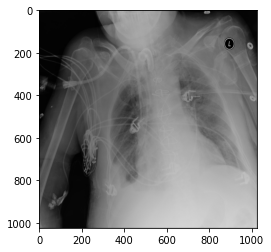

In [14]:
plt.imshow(im)

### Bounding Box

In [15]:
print(np.max(Y), np.min(Y))

1.0 0.0


In [16]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([507., 181., 585., 267.], dtype=float32)

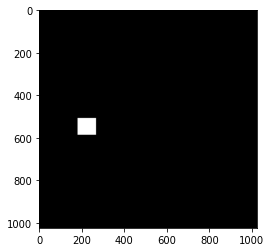

In [17]:
plt.imshow(Y, cmap='gray')

## GradCAM

In [36]:
cam1 = np.load("D:\\Data\\AI604_project\\gradCAM\\00010007_168.npy")
cam2 = (np.load("D:\\Data\\AI604_project\\gradCAM\\00012515_002.npy"))
cam3 = np.load("D:\\Data\\AI604_project\\gradCAM\\00015770_010.npy")
cam = np.stack((cam1, cam2, cam3), axis=0)
cam.shape

(3, 1024, 1024)

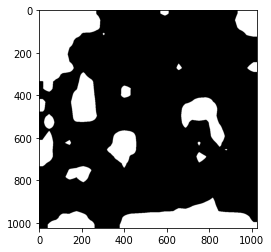

In [37]:
cam1 = np.where(cam1>0.1, 1.0, 0.0)
plt.imshow(cam1, cmap='gray')

In [38]:
print(np.max(cam1), np.min(cam1))

1.0 0.0


## IoU

In [39]:
print(Y.shape, cam1.shape)
print(type(Y), type(cam1))

(1024, 1024) (1024, 1024)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [32]:
SMOOTH = 1e-6

def iou_numpy(outputs: np.array, labels: np.array):
    # outputs = outputs.squeeze(1)

    outputs = outputs.astype(int)
    labels = labels.astype(int)
    
    intersection = (outputs & labels).sum((0,1))
    union = (outputs | labels).sum((0,1))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    print("before np.ceil ", iou)
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()


In [40]:
threshold = iou_numpy(Y, cam1)
threshold

before np.ceil  0.041458504824567616


0.0

## Test 3 images

=========== Sample  0


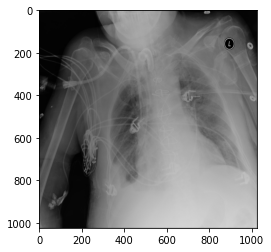

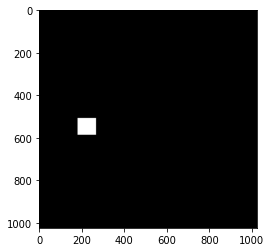

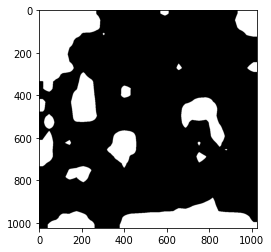

before np.ceil  0.006001345360911671
IOU :  0.0
=========== Sample  1


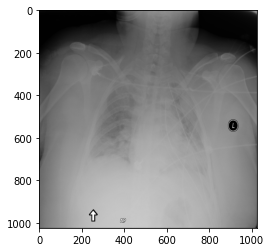

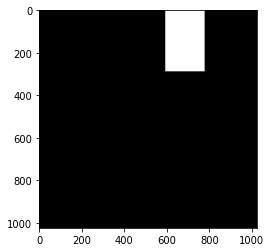

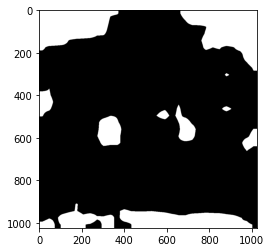

before np.ceil  0.031560311303961905
IOU :  0.0
=========== Sample  2


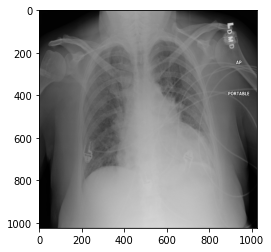

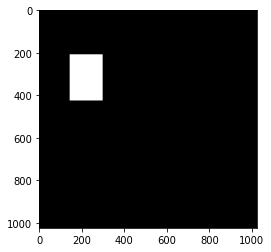

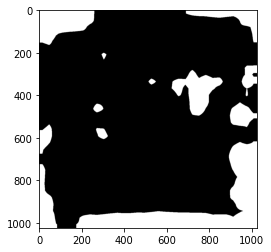

before np.ceil  0.000155277552321587
IOU :  0.0


In [34]:
for row in range(len(sample_df)) :
    print("=========== Sample ",row)
    im = cv2.imread(str(sample_df.values[row][0]))
    bb = create_bb_array(df_train.values[row])
    Y = create_mask(bb, im)
    mask_to_bb(Y)
    plt.imshow(im)
    plt.show()
    plt.imshow(Y, cmap='gray')
    plt.show()
    
    cam_sample = cam[row]
    cam_sample = np.where(cam_sample>0.1, 1.0, 0.0)
    plt.imshow(cam_sample, cmap='gray')
    plt.show()

    threshold = iou_numpy(Y, cam_sample)
    print("IOU : " ,threshold)
    